<ipython-input-9-0c141afa45cc>:20: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)
<ipython-input-9-0c141afa45cc>:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['price'] = pd.to_numeric(df['price'], errors='coerce')
<ipython-input-9-0c141afa45cc>:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)



Vehicle Age Distribution:
age
0.0      8937
1.0     11006
2.0     16336
3.0     15597
4.0     12675
5.0     12071
6.0     12550
7.0     14066
8.0     10822
9.0      9074
10.0     7145
11.0     5786
12.0     7970
13.0     6899
14.0     6237
15.0     5109
16.0     4349
17.0     3674
18.0     2835
19.0     2243
20.0     1739
21.0     1586
22.0     1037
23.0      892

Model Performance:
| Metric                | Value         |
|-----------------------|---------------|
| Min Age               | 0.0           |
| Max Age               | 23.0          |
| MAE                   | $3,834.63     |
| MSE                   | 26,803,420.00 |
| RMSE                  | $5,177.20     |
| R² Score              | 0.78          |
| MAPE                  | 32.67%        |
| Median Absolute Error | $2,853.16     |
| Explained Variance    | 0.78          |


<ipython-input-9-0c141afa45cc>:103: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='importance_mean', y='feature', data=top_features, palette='viridis')


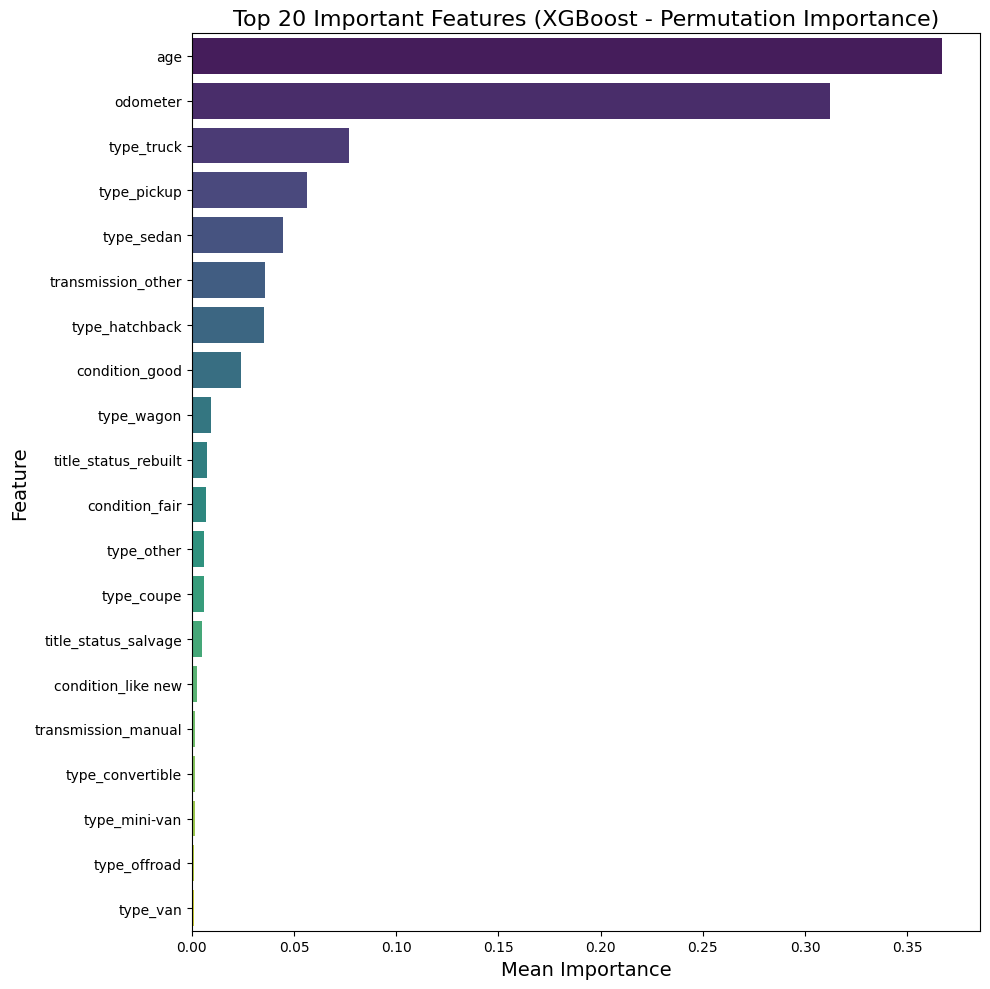

<ipython-input-9-0c141afa45cc>:124: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample_input[['odometer']] = scaler.transform(sample_input[['odometer']])



Predicted Price for sample input: $18,336.73


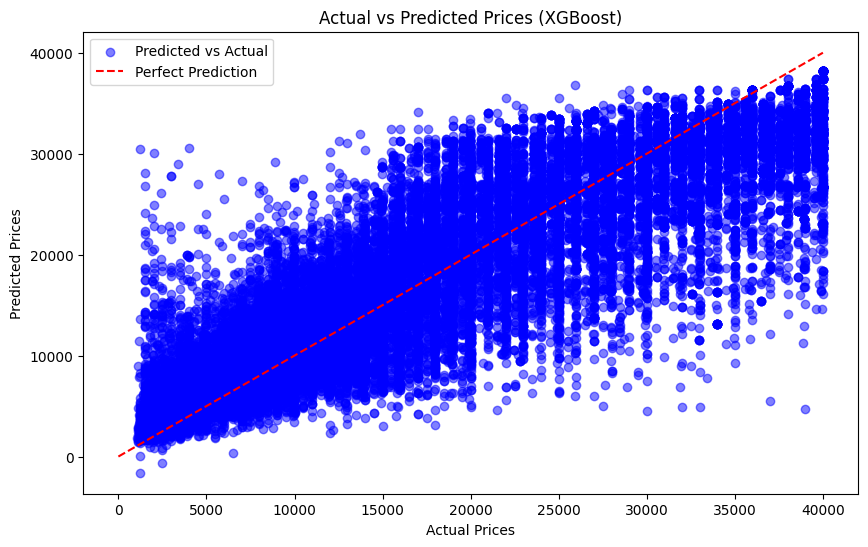

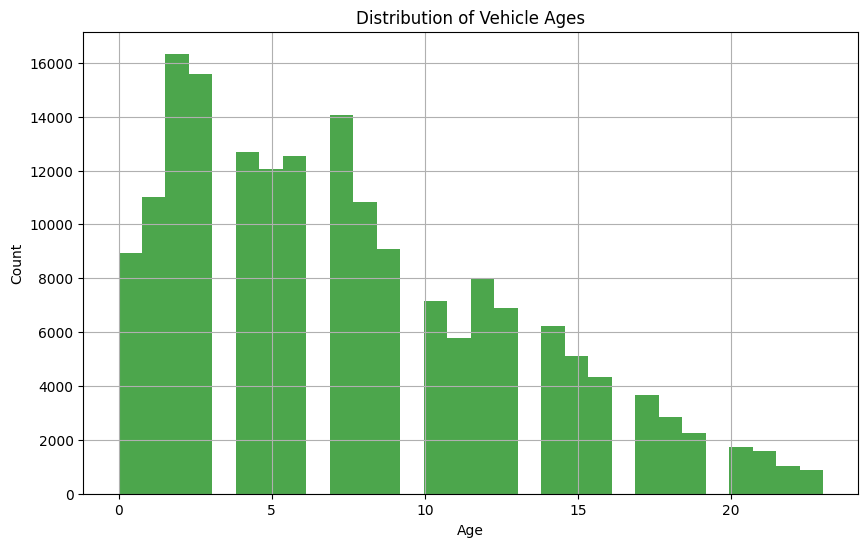

In [9]:
# XGBoost Block
import kagglehub
from kagglehub import KaggleDatasetAdapter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    mean_absolute_error, r2_score, mean_squared_error,
    mean_absolute_percentage_error, median_absolute_error, explained_variance_score
)
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.inspection import permutation_importance


# Load dataset from KaggleHub
file_path = "vehicles.csv"
df = kagglehub.load_dataset(KaggleDatasetAdapter.PANDAS, "austinreese/craigslist-carstrucks-data", file_path)

# Drop unused columns
unused_cols = ['state','fuel','drive','manufacturer','cylinders','id', 'url', 'region', 'region_url',
               'VIN', 'image_url', 'description', 'county', 'lat', 'long', 'posting_date']
df.drop(columns=unused_cols, inplace=True)

# Select relevant and clean data
df = df[['price', 'year', 'condition', 'odometer', 'title_status', 'transmission', 'type']]
df['price'] = pd.to_numeric(df['price'], errors='coerce')
df.dropna(inplace=True)
df = df[(df['price'] > 1000) & (df['price'] <= 40000)]
df = df[(df['year'] >= 1997) & (df['year'] <= 2020)]

# Add 'age' and one-hot encode categoricals
df['age'] = 2020 - df['year']
df.drop(columns='year', inplace=True)
df = pd.get_dummies(df, columns=['transmission', 'type', 'condition', 'title_status'], drop_first=True)

# Split features and target
X = df.drop(columns='price')
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale odometer
scaler = StandardScaler()
X_train[['odometer']] = scaler.fit_transform(X_train[['odometer']])
X_test[['odometer']] = scaler.transform(X_test[['odometer']])

# Train XGBoost model
xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, verbosity=0)
xgb_model.fit(X_train, y_train)
xgb_preds = xgb_model.predict(X_test)

# Evaluation metrics
mae = mean_absolute_error(y_test, xgb_preds)
mse = mean_squared_error(y_test, xgb_preds)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, xgb_preds)
mape = mean_absolute_percentage_error(y_test, xgb_preds)
medae = median_absolute_error(y_test, xgb_preds)
evs = explained_variance_score(y_test, xgb_preds)

# Print Vehicle Age Distribution
print("\nVehicle Age Distribution:")
print(df['age'].value_counts().sort_index().to_string())

# Print Model Performance Table
print("\nModel Performance:")
from tabulate import tabulate
print(tabulate([
    ['Min Age', df['age'].min()],
    ['Max Age', df['age'].max()],
    ['MAE', f"${mae:,.2f}"],
    ['MSE', f"{mse:,.2f}"],
    ['RMSE', f"${rmse:,.2f}"],
    ['R² Score', f"{r2:.2f}"],
    ['MAPE', f"{mape * 100:.2f}%"],
    ['Median Absolute Error', f"${medae:,.2f}"],
    ['Explained Variance', f"{evs:.2f}"]
], headers=['Metric', 'Value'], tablefmt='github'))

# # Feature Importance Plot
# importances = xgb_model.feature_importances_
# indices = np.argsort(importances)[::-1]  # Sort feature importances in descending order

# plt.figure(figsize=(10,6))
# plt.title('Feature Importance')
# plt.barh(range(X_train.shape[1]), importances[indices], align='center')
# plt.yticks(range(X_train.shape[1]), [X_train.columns[i] for i in indices])
# plt.xlabel('Relative Importance')
# plt.show()

xgb_importance = permutation_importance(xgb_model, X_test, y_test, n_repeats=10, random_state=42)
xgb_df = pd.DataFrame({
    'feature': X_test.columns,
    'importance_mean': xgb_importance.importances_mean,
    'importance_std': xgb_importance.importances_std
}).sort_values(by='importance_mean', ascending=False)
top_n = 20
top_features = xgb_df.head(top_n)

plt.figure(figsize=(10, 10))
sns.barplot(x='importance_mean', y='feature', data=top_features, palette='viridis')
plt.title(f'Top {top_n} Important Features (XGBoost - Permutation Importance)', fontsize=16)
plt.xlabel('Mean Importance', fontsize=14)
plt.ylabel('Feature', fontsize=14)
plt.tight_layout()
plt.show()
# Predict a sample input
sample_input = pd.DataFrame({
    'odometer': [45000],
    'age': [2020 - 2015],
    'transmission_manual': [0],
    'type_sedan': [1],
    'condition_good': [1],
    'title_status_clean': [1]
})

# Add missing columns
for col in X_train.columns:
    if col not in sample_input.columns:
        sample_input[col] = 0
sample_input = sample_input[X_train.columns]
sample_input[['odometer']] = scaler.transform(sample_input[['odometer']])

predicted_price = xgb_model.predict(sample_input)[0]
print(f"\nPredicted Price for sample input: ${predicted_price:,.2f}")

# Plot: Actual vs Predicted Prices
plt.figure(figsize=(10,6))
plt.scatter(y_test, xgb_preds, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([0, max(y_test)], [0, max(y_test)], color='red', linestyle='--', label="Perfect Prediction")
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs Predicted Prices (XGBoost)')
plt.legend()
plt.show()

# Plot: Age distribution
plt.figure(figsize=(10,6))
df['age'].hist(bins=30, color='green', alpha=0.7)
plt.title("Distribution of Vehicle Ages")
plt.xlabel("Age")
plt.ylabel("Count")
plt.show()